In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib import Policy

import IPython.core.display_functions

from src.parsers import HMParser, CotevParser
from src.resources import Aggregator, Generator, Load, Storage
from src.algorithms.rl import EnergyCommunityBaselineV1, EnergyCommunityBaselineV2

import warnings
warnings.filterwarnings('ignore')

2024-08-11 05:37:04,017	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

# EC data for non-renewable generators and batteries
data_ec = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data_ec.parse()

# EV data from the EV4EU simulator
data_ev = CotevParser(population_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/population_731.csv',
                      driving_history_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/ev_driving_history_731.csv',
                      assigned_segments_path='/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/assigned_segments_731.csv',
                      parse_date_start='2019',
                      parse_date_end='2020')
data_ev.parse()

In [3]:
# UPAC Data load

data_upacs = {}
for i in glob.glob('/Users/ecgomes/Documents/PhD/UPAC data/upac*_pv.csv'):
    temp = pd.read_csv(i, index_col=0, parse_dates=True)
    temp = temp.resample('H').mean()

    # Need to divide by 1000 to convert from W to kW
    temp['pv'] = temp['pv'] / 1000
    temp['load'] = temp['load'] / 1000

    # Set any negative values to zero
    temp.loc[temp['pv'] < 0, 'pv'] = 0
    temp.loc[temp['load'] < 0, 'load'] = 0

    # We only want 2019 and 2020 data
    temp = temp.loc['2019':'2020']

    # Fill potential NaN values with interpolation
    temp = temp.interpolate()

    name = i.split('/')[-1].split('_')[0].split('upac')[1]

    data_upacs[name] = temp

In [4]:
# Train resource creation

def create_resources(upacs, ec, ev):
    """
    Create the resources for the training environment.
    return a list of resources.
    :param upacs: dict with the UPAC data
    :param ec: dict with the EC data
    :param ev: dict with the EV data
    """

    resources = []
    # Add generators (from pv column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Generator(
            name='ren_generator_' + current_name,
            value=np.zeros(upacs[current_name]['pv'].shape),
            lower_bound=np.zeros(upacs[current_name]['pv'].shape),
            upper_bound=upacs[current_name]['pv'].values,
            cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs[current_name].shape[0]),
            cost_nde=np.tile(ec.generator['cost_nde'][0], (int(upacs[current_name].shape[0] / 24))),
            is_renewable=True))

    '''
    resources.append(Generator(
        name='generator_14',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    
    resources.append(Generator(
        name='generator_15',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    '''

    # Add loads (from load column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Load(
            name='load_' + current_name,
            value=upacs[current_name]['load'],
            lower_bound=np.zeros(upacs[current_name].shape),
            upper_bound=upacs[current_name]['load'].values,
            cost=np.ones(upacs[current_name].shape[0]),
            cost_cut=np.tile(ec.load['cost_cut'][0], (int(upacs[current_name].shape[0] / 24))),
            cost_reduce=np.tile(ec.load['cost_reduce'][0], (int(upacs[current_name].shape[0] / 24))),
            cost_ens=np.tile(ec.load['cost_ens'][0], (int(upacs[current_name].shape[0] / 24)))))

    # Add storage (from the EC data)
    for i in range(ec.storage['p_charge_limit'].shape[0]):
        resources.append(Storage(
            name='storage_{:02d}'.format(i+1),
            value=ec.storage['initial_state'][i] * np.ones(upacs['02'].shape[0]),
            lower_bound=np.ones(upacs['02'].shape[0]) * ec.storage['energy_min_percentage'][i],
            upper_bound=(ec.storage['energy_capacity'][i] * np.ones(upacs['02'].shape[0])),
            cost=np.ones(upacs['02'].shape[0]),
            cost_discharge=np.tile(ec.storage['discharge_price'][i], (int(upacs['02'].shape[0] / 24))),
            cost_charge=np.tile(ec.storage['charge_price'][i], (int(upacs['02'].shape[0] / 24))),
            capacity_max=ec.storage['energy_capacity'][i],
            capacity_min=ec.storage['energy_min_percentage'][i],
            initial_charge=ec.storage['initial_state'][i],
            discharge_efficiency=ec.storage['discharge_efficiency'][i],
            discharge_max=np.tile(ec.storage['p_discharge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            charge_efficiency=ec.storage['charge_efficiency'][i],
            charge_max=np.tile(ec.storage['p_charge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            capital_cost=np.array([0.05250, 0.10500, 0.01575])))

    # Add vehicles (from the EV data)
    for i in np.arange(len(ev)):
        # Append to the list of resources
        resources.append(ev[i])

    # Append Aggregator
    resources.append(Aggregator(
        name='aggregator',
        value=np.zeros(upacs['02'].shape[0]),
        lower_bound=np.zeros(upacs['02'].shape[0]),
        upper_bound=np.tile(ec.peers['import_contracted_p_max'][0, 0], (upacs['02'].shape[0])),
        cost=np.tile(ec.peers['buy_price'][0, 0], (upacs['02'].shape[0])),
        imports=np.zeros(upacs['02'].shape[0]),
        exports=np.zeros(upacs['02'].shape[0]),
        import_cost=np.tile(ec.peers['buy_price'][0], (int(upacs['02'].shape[0] / 24))), # * 100,
        export_cost=np.tile(ec.peers['sell_price'][0], (int(upacs['02'].shape[0] / 24))),
        import_max=np.tile(ec.peers['import_contracted_p_max'][0, 0], (int(upacs['02'].shape[0]))),
        export_max=np.tile(ec.peers['export_contracted_p_max'][0, 0], (int(upacs['02'].shape[0])))))

    return resources

In [5]:
# Create resources for the training environment

def iterate_resources(u, c, e, mode='daily'):

    temp = {}

    # Save first key of upac data
    first_key = list(u.keys())[0]

    if mode is 'daily':

        # Loop to iterate over days in the datasets
        for i in np.unique(u[first_key].index.date):
            # Create the resources for the training environment

            date = i.strftime('%Y-%m-%d')

            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)

            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)

    elif mode is 'monthly':

        # Loop to iterate over months in the datasets
        # Need to be careful with different years
        unique_months = np.unique(data_upacs['02'].index.strftime('%Y-%m'))

        for i in unique_months:
            # Create the resources for the training environment
            date = i

            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)

            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)

    elif mode is 'yearly':

        # Loop to iterate over years in the datasets
        unique_years = np.unique(data_upacs['02'].index.strftime('%Y'))

        for i in unique_years:
            # Create the resources for the training environment
            date = i

            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)

            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)

    return temp

dataset_resources = iterate_resources(u=data_upacs, c=data_ec, e=data_ev, mode='daily')

In [6]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunityBaselineV2(ren_generators=dataset_resources[list(dataset_resources.keys())[0]][:5],
                                     generators=[],#dataset_resources[list(dataset_resources.keys())[0]][5:7],
                                     loads=dataset_resources[list(dataset_resources.keys())[0]][5:10],
                                     storages=dataset_resources[list(dataset_resources.keys())[0]][10:13],
                                     evs=dataset_resources[list(dataset_resources.keys())[0]][13:-1],
                                     aggregator=dataset_resources[list(dataset_resources.keys())[0]][-1],
                                     ev_penalty=1,
                                     balance_penalty=1)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:

    actions = temp_env.action_space_sample()
    next_obs, rewards, terminations, truncations, infos = temp_env.step(actions)
    
    #print(next_obs.keys())

print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [7]:
# Create the policies dictionary

def assign_group_policies(env):

    policies = {'generator_renewable': (None,
                                        env.observation_space['ren_generator_08'],
                                        env.action_space['ren_generator_08'],
                                        {}),
                'storage': (None,
                            env.observation_space['storage_01'],
                            env.action_space['storage_01'],
                            {}),
                'ev': (None,
                       env.observation_space['ev_01'],
                       env.action_space['ev_01'],
                       {}),
                #'generator_non_renewable': (None,
                #              env.observation_space['generator_14'],
                #              env.action_space['generator_14'],
                #              {}),
                }

    return policies

def assign_group_policies_v2(env):

    policies = {'ren_08': (None,
                           env.observation_space['ren_generator_08'],
                           env.action_space['ren_generator_08'],
                           {}),
                'ren_09': (None,
                           env.observation_space['ren_generator_09'],
                           env.action_space['ren_generator_09'],
                           {}),
                'ren_02': (None,
                           env.observation_space['ren_generator_02'],
                           env.action_space['ren_generator_02'],
                           {}),
                'ren_06': (None,
                           env.observation_space['ren_generator_06'],
                           env.action_space['ren_generator_06'],
                           {}),
                'ren_13': (None,
                           env.observation_space['ren_generator_13'],
                           env.action_space['ren_generator_13'],
                           {}),
                'storage_01': (None,
                               env.observation_space['storage_01'],
                               env.action_space['storage_01'],
                               {}),
                'storage_02': (None,
                               env.observation_space['storage_02'],
                               env.action_space['storage_02'],
                               {}),
                'storage_03': (None,
                               env.observation_space['storage_03'],
                               env.action_space['storage_03'],
                               {}),
                'ev_01': (None,
                          env.observation_space['ev_01'],
                          env.action_space['ev_01'],
                          {}),
                'ev_02': (None,
                          env.observation_space['ev_02'],
                          env.action_space['ev_02'],
                          {}),
                'ev_03': (None,
                          env.observation_space['ev_03'],
                          env.action_space['ev_03'],
                          {}),
                'ev_04': (None,
                          env.observation_space['ev_04'],
                          env.action_space['ev_04'],
                          {}),
                'ev_05': (None,
                          env.observation_space['ev_05'],
                          env.action_space['ev_05'],
                          {}),
                }

    return policies

policies = assign_group_policies_v2(env=temp_env)

In [8]:
import logging
# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

from ray.tune import register_env
from ray.train import Checkpoint

ray.shutdown()
ray.init()

IMPORT_PENALTY = 1 #100
EXPORT_PENALTY = 1 #10
STORAGE_ACTION_PENALTY = 1 #1000
STORAGE_ACTION_REWARD = 5 #10
EV_ACTION_PENALTY = 1 #1000
EV_ACTION_REWARD = 5 #10
EV_REQUIREMENT_PENALTY = 100 #3000
BALANCE_PENALTY = 2000 #20000

checkpoint = None
checkpoint_path = None
algo = None

# Months per day:
# January: 0:31 -> DONE
# February: 31:59 -> DONE
# March: 59:90 -> DONE
# April: 90:120 -> DONE
# May: 120:151 -> DONE
# June: 151:181 -> DONE
# July: 181:212 -> DONE
# August: 212:243 -> DONE
# September: 243:273 -> DONE
# October: 273:304 -> DONE
# November: 304:334 -> DONE
# December: 334:365 -> 

# Build a loop for using separate resources on a daily basis
for datapoint in list(dataset_resources.keys())[334:365]:
    
    temp_resources = dataset_resources[datapoint]

    register_env("EC_Multi", lambda config: EnergyCommunityBaselineV2(ren_generators=temp_resources[:5],
                                                                      generators=[],#temp_resources[5:7],
                                                                      loads=temp_resources[5:10],
                                                                      storages=temp_resources[10:13],
                                                                      evs=temp_resources[13:-1],
                                                                      aggregator=temp_resources[-1],
                                                                      ev_penalty=EV_REQUIREMENT_PENALTY,
                                                                      balance_penalty=BALANCE_PENALTY)
                 )

    # Define the PPOConfig
    config = PPOConfig()\
        .environment(env="EC_Multi", disable_env_checking=False)\
        .training(train_batch_size=360,
                  lr=2e-4, #tune.grid_search([0.001, 0.0001]),
                  gamma=0.99,
                  use_gae=True,
                  use_critic=True)\
        .framework('torch') \
        .rollouts(batch_mode='complete_episodes',
                  num_rollout_workers=1,
                  rollout_fragment_length='auto')\
        .multi_agent(policies=policies,
                     policy_mapping_fn=(lambda agent_id, episode, worker, **kwargs:
                                        'ren_08' if agent_id.startswith('ren_generator_08') else
                                        'ren_09' if agent_id.startswith('ren_generator_09') else
                                        'ren_02' if agent_id.startswith('ren_generator_02') else
                                        'ren_06' if agent_id.startswith('ren_generator_06') else
                                        'ren_13' if agent_id.startswith('ren_generator_13') else
                                        'storage_01' if agent_id.startswith('storage_01') else
                                        'storage_02' if agent_id.startswith('storage_02') else
                                        'storage_03' if agent_id.startswith('storage_03') else
                                        'ev_01' if agent_id.startswith('ev_01') else
                                        'ev_02' if agent_id.startswith('ev_02') else
                                        'ev_03' if agent_id.startswith('ev_03') else
                                        'ev_04' if agent_id.startswith('ev_04') else
                                        'ev_05'))

    #results = tune.run(
    #    "PPO",
    #    stop={"training_iteration": 100},
    #    config=config.to_dict(),
    #    checkpoint_at_end=True,
    #    verbose=0,
    #)
    algo = config.build()
    
    # Load the checkpoint if it exists
    
    if checkpoint is not None:
        policy = Policy.from_checkpoint(checkpoint.checkpoint.path)
    
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    elif checkpoint_path is not None:
        checkpoint = Checkpoint.from_directory(checkpoint_path)
        policy = Policy.from_checkpoint(checkpoint)
    
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    
    
    # Clear the Jupyter cell output
    IPython.core.display_functions.clear_output()
    
    # Train for n iterations and report results (mean episode rewards)
    print(f"Datapoint {datapoint}\n")
    # for i in range(100):
    #    results = algo.train()
    #    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    #    if results['episode_reward_mean'] > 500:
    #        break

    #if results['episode_reward_mean'] < 500:
    #    # Save the checkpoint to disk.
    #    checkpoint = algo.save()

    #else:
    #    break

    for i in range(100):
        results = algo.train()
        print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
        # print(f"Policy rewards: {results['policy_reward_mean']}")
        if results['episode_reward_mean'] > 500:
            break



    if results['episode_reward_mean'] < 500:
        # Save the checkpoint to disk.
        checkpoint = algo.save()
        #algo.save('/Users/ecgomes/DataspellProjects/pyecom/models/baseline_v5_nogen_{}'.format(datapoint))

    else:
        break
    #print("checkpoints saved at", checkpoint)

Datapoint 2019-12-31
Iter: 0; avg. reward=-35.88514944170636
Iter: 1; avg. reward=-37.31131731259869
Iter: 2; avg. reward=-36.86390025759966
Iter: 3; avg. reward=-35.33956134775458
Iter: 4; avg. reward=-33.96657836699414
Iter: 5; avg. reward=-32.2607984464739
Iter: 6; avg. reward=-30.360900281551018
Iter: 7; avg. reward=-27.808671944878174
Iter: 8; avg. reward=-24.759611421504484
Iter: 9; avg. reward=-22.635377317888857
Iter: 10; avg. reward=-20.44823775059199
Iter: 11; avg. reward=-18.714515452551034
Iter: 12; avg. reward=-17.61963023642807
Iter: 13; avg. reward=-16.878849286119916
Iter: 14; avg. reward=-16.280584844878728
Iter: 15; avg. reward=-15.774658843372801
Iter: 16; avg. reward=-15.416548203963371
Iter: 17; avg. reward=-15.373779605176173
Iter: 18; avg. reward=-15.131109055175214
Iter: 19; avg. reward=-15.006222279612077
Iter: 20; avg. reward=-14.906820865939975
Iter: 21; avg. reward=-14.792527110572337
Iter: 22; avg. reward=-14.762587747591194
Iter: 23; avg. reward=-14.717592

In [12]:
list(dataset_resources.keys())[343]

'2019-12-10'

In [9]:
algo.save('/Users/ecgomes/DataspellProjects/pyecom/models/baseline_v5_nogen_daily_2019-01-12')

TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/Users/ecgomes/DataspellProjects/pyecom/models/baseline_v5_nogen_daily_2019-01-12), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'__all__': {'num_agent_steps_trained': 1664.0, 'num_env_steps_trained': 360.0, 'total_loss': -0.09104673941345776}, 'ren_08': {'total_loss': -0.09104673941345776, 'policy_loss': 0.0008884660023100236, 'vf_loss': 0.0004707446921041564, 'vf_loss_unclipped': 0.0004707446921041564, 'vf_explained_var': 0.9953787929871503, 'entropy': -0.2839029988821815, 'mean_kl_loss': 0.007534043919461992, 'default_optimizer_lr': 0.00019999999999999998, 'curr_lr': 0.0002, 'curr_entropy_coeff': 0.0, 'curr_kl_coeff': 0.018040671944618225}, 'ren_06': {'total_loss': -0.009547157960889095, 'policy_loss': -0.014523151867529924, 'vf_loss': 0.0004652452773263897, 'vf_loss_unclipped': 0.0004652452773263897, 'vf_explained_var': 0.9954058801426607, 'entropy': -0.6455566616619335, 'mean_kl_loss': 0.027781

In [14]:
checkpoint.checkpoint.path

'/var/folders/th/r7sxqq0x56d07db0rvxmgxdc0000gn/T/tmp5oi6e5pv'

In [13]:
list(dataset_resources.keys())[303]

'2019-10-31'

In [16]:
# Check the results
# Create a new env

test_resources = dataset_resources[list(dataset_resources.keys())[0]]

test_env = EnergyCommunityBaselineV0(ren_generators=test_resources[:5],
                                     generators=test_resources[5:7],
                                     loads=test_resources[7:12],
                                     storages=test_resources[12:15],
                                     evs=test_resources[15:-1],
                                     aggregator=test_resources[-1],
                                     ev_penalty=1,
                                     balance_penalty=BALANCE_PENALTY)

obs, info = test_env.reset()

# Set up the terminations and truncations
terminations = truncations = {a: False for a in test_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False

while not terminations['__all__'] and not truncations['__all__']:

    action_dict = {}

    for current_agent in test_env.agents:
        current_policy = 'generator_renewable' if current_agent.startswith('ren_gen') else \
            'storage' if current_agent.startswith('storage') else \
                'ev' if current_agent.startswith('ev') else \
                    'generator_non_renewable'

        action_dict[current_agent] =  algo.compute_single_action(observation=obs[current_agent],
                                                                 policy_id=current_policy)

    obs, rewards, terminations, truncations, info = test_env.step(action_dict)

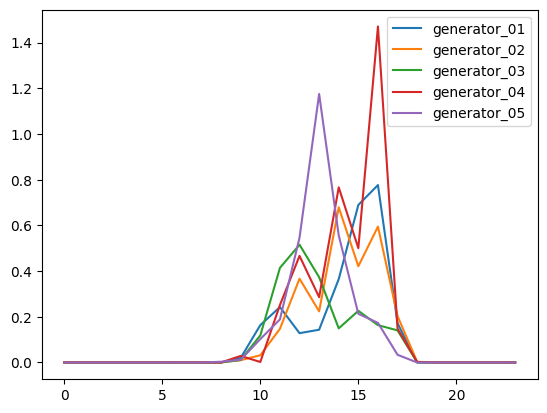

In [17]:
# Plot the generator power output

plt.figure()

for i in range(5):
    plt.plot(test_env.ren_generators[i].value)

plt.legend(['generator_{:02d}'.format(i+1) for i in range(data_ec.generator['p_forecast'].shape[0])])
plt.show()

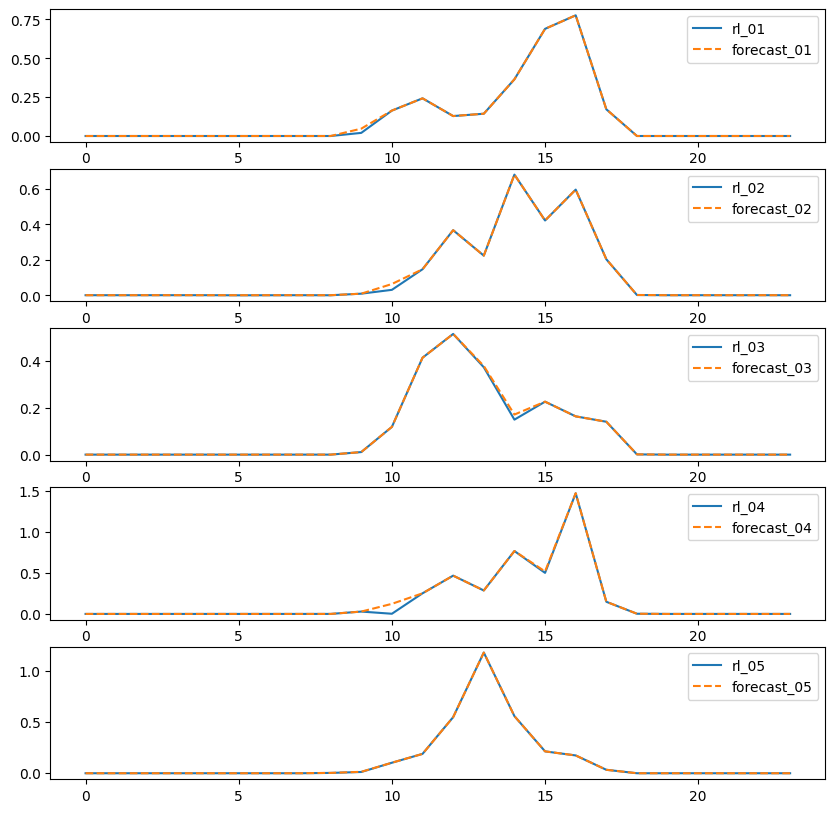

In [18]:
# Create subplots with the generator values and the forecast

fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i in np.arange(5):
    axs[i].plot(test_env.ren_generators[i].value, label='rl_{:02d}'.format(i+1))
    axs[i].plot(data_upacs[list(data_upacs.keys())[i]]['pv'].loc['2019-01-01'].values, label='forecast_{:02d}'.format(i+1),
                linestyle='--')
    
    axs[i].legend()
    
plt.show()

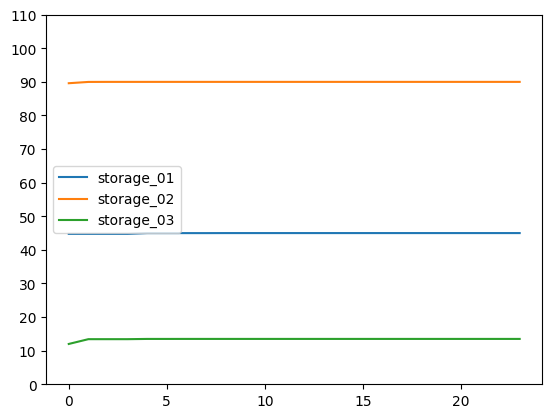

In [19]:
# Plot the storage state of charge

plt.figure()

for i in range(data_ec.storage['p_charge_limit'].shape[0]):
    plt.plot(test_env.storages[i].value * test_env.storages[i].capacity_max)
    
plt.yticks(np.arange(0, 120, 10))

plt.legend(['storage_{:02d}'.format(i+1) for i in range(data_ec.storage['p_charge_limit'].shape[0])])
plt.show()

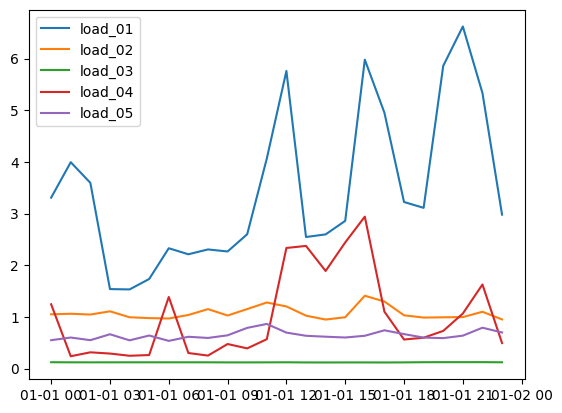

In [20]:
# Plot the load values

plt.figure()

for i in range(5):
    plt.plot(test_env.loads[i].value)
    
plt.legend(['load_{:02d}'.format(i+1) for i in range(5)])
plt.show()

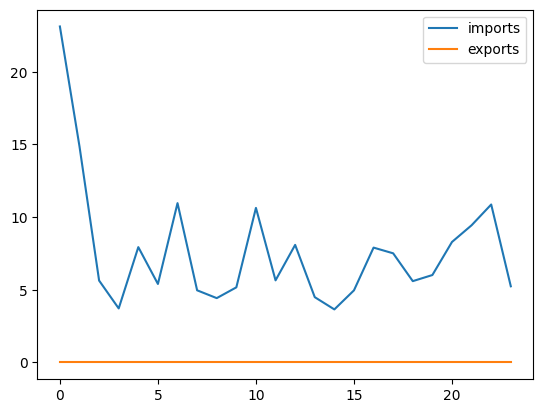

In [21]:
# Check imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports, label='imports')
plt.plot(test_env.aggregator.exports, label='exports')

plt.legend()
plt.show()

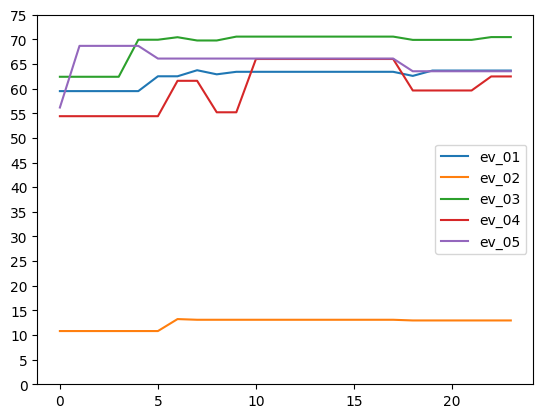

In [22]:
# Check EVs

plt.figure()

for ev in test_env.evs:
    plt.plot(ev.value * ev.capacity_max, label=ev.name)

plt.yticks(np.arange(0, 80, 5))
plt.legend()

plt.show()

In [25]:
for ev in test_env.evs:
    print(ev.name)
    print(ev.charge)

ev_01
[1.66405103 0.         0.         0.         0.         1.50487034
 0.         0.61394152 0.         0.25548678 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.54225058 0.         0.         0.         0.        ]
ev_02
[0.    0.    0.    0.    0.    0.    1.215 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
ev_03
[0.         0.         0.         0.         3.75827514 0.
 0.25510475 0.         0.         0.3930842  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.28270064 0.        ]
ev_04
[0.         0.         0.         0.         0.         0.
 3.59034654 0.         0.         0.         5.40675623 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.42397501 0.        ]
ev_05
[0.         6.25583436 0.         0.         0.         0.
 0.         0.         0

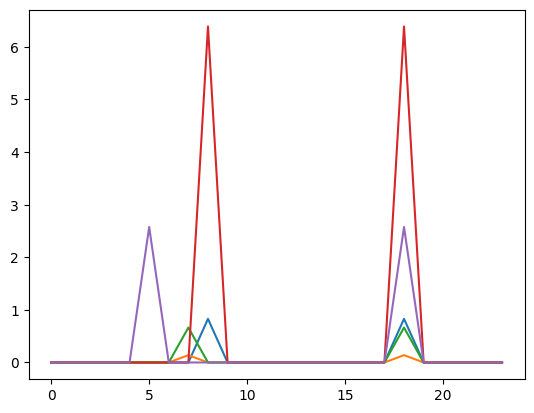

In [19]:
for i in range(len(test_env.evs)):
    plt.plot(test_env.evs[i].schedule_requirement_soc)

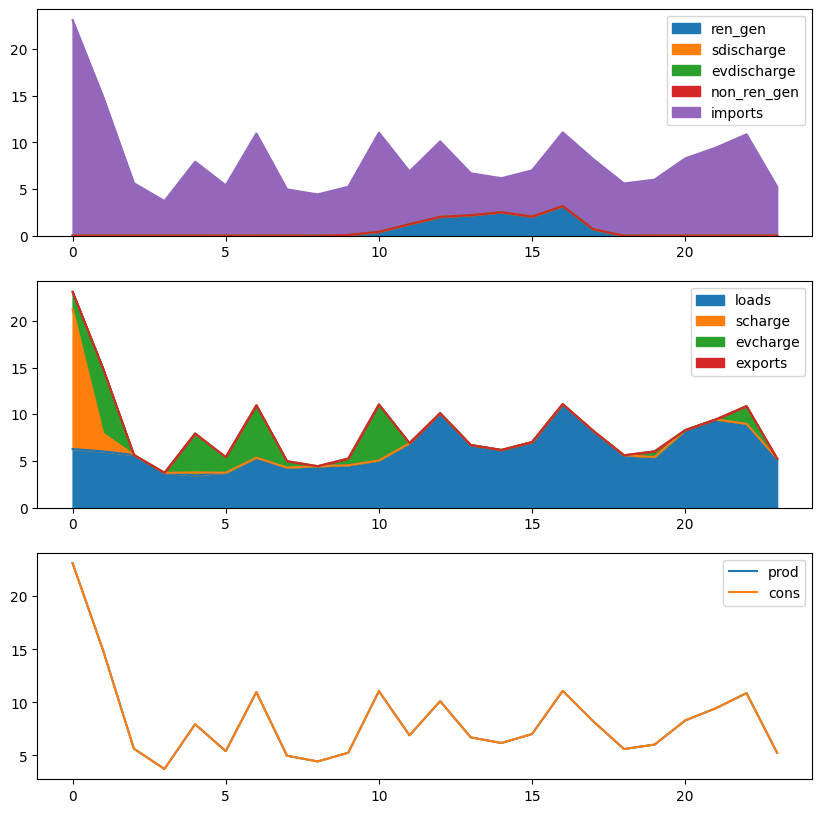

In [24]:
# Check the sum of values

test_prod = pd.DataFrame({'ren_gen': np.sum([test_env.ren_generators[i].value for i in range(5)], axis=0),
                          'sdischarge': np.sum([test_env.storages[i].discharge for i in range(3)], axis=0),
                          'evdischarge': np.sum([test_env.evs[i].discharge for i in range(5)], axis=0),
                          'non_ren_gen': np.sum([test_env.generators[i].value for i in range(2)], axis=0),
                          'imports': test_env.aggregator.imports})

test_cons = pd.DataFrame({'loads': np.sum([test_env.loads[i].value for i in range(5)], axis=0),
                          'scharge': np.sum([test_env.storages[i].charge / test_env.storages[i].charge_efficiency 
                                             for i in range(3)], axis=0),
                          'evcharge': np.sum([test_env.evs[i].charge / test_env.evs[i].charge_efficiency 
                                              for i in range(5)], axis=0),
                          'exports': test_env.aggregator.exports})

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

test_prod.plot(kind='area', ax=axs[0])
test_cons.plot(kind='area', ax=axs[1])

axs[2].plot(test_prod.sum(axis=1)[0:], label='prod')
axs[2].plot(test_cons.sum(axis=1)[0:], label='cons')

plt.legend()
plt.show()

In [23]:
test_prod

,ren_gen,sdischarge,evdischarge,non_ren_gen,imports
0,0.000158,0.0,0.0,0.0,2.888731
1,0.001392,0.0,0.0,0.0,6.013197
2,0.001374,0.0,0.0,0.0,5.621742
3,0.001527,0.0,0.0,0.0,8.589094
4,0.001438,0.0,0.0,0.0,9.318465
5,0.001410,0.0,0.0,0.0,5.079485
6,0.001417,0.0,0.0,0.0,5.337770
7,0.001219,0.0,0.0,0.0,7.050895
8,0.004899,0.0,0.0,0.0,4.415120
9,0.110892,0.0,0.0,0.0,11.558102


In [24]:
test_cons

,loads,scharge,evcharge,exports
0,6.272973,0.000000e+00,2.888888,0.0
1,6.014588,9.113559e+00,0.000000,0.0
2,5.623117,6.950230e+00,0.000000,0.0
3,3.720585,1.147012e+00,4.870036,0.0
4,3.437838,4.604298e-02,5.882065,0.0
5,3.730895,1.849844e-03,1.350000,0.0
6,5.339187,2.031250e-06,0.000000,0.0
7,4.285127,7.247032e-05,2.766987,0.0
8,4.420018,2.899829e-06,0.000000,0.0
9,4.530002,1.160439e-07,7.138992,0.0


In [23]:
test_env.aggregator.imports

array([10.75382632, 12.81458833,  5.62311667,  3.720585  , 12.44869119,
        5.080895  ,  5.65875177,  4.28512667,  4.42001833,  4.53000167,
        5.04745667,  6.89479833, 10.114815  ,  6.696835  ,  6.16782333,
        7.01326   , 11.08323333,  8.20876167,  5.60267833,  5.41581   ,
        8.29380167,  9.44345333,  8.97574   ,  5.24343333])